<a href="https://colab.research.google.com/github/JJang-likit/GoingDeeper_Aiffel/blob/main/GoingDeeper_CutMix_and_Mixup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GoingDeeper / CutMix and Mixup Project

## 목차
1. Augmentation을 적용한 데이터셋 만들기
  - 기본적인 Augmentation이 적용된 데이터셋
  - 아무것도 적용되지 않은 데이터셋
  - CutMix가 적용된 데이터셋
  - Mixup이 적용된 데이터셋
2. 모델 만들기(각각의 데이터셋을 이용해서 구성)
  - 아무것도 적용되지 않은 데이터셋
  - 기본적인 augmentation이 적용된 데이터셋
  - CutMix가 적용된 데이터셋
  - Mixup이 적용된 데이터셋
3. 모델 훈련 및 시각화
4. 정리 및 회고

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


In [2]:
# GPU 환경 확인

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# 사용할 데이터셋 불러오기 / stanford_dogs

(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', split = ['train', 'test'], as_supervised=True, shuffle_files = True, with_info = True)
print('good')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteEC4NON/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteEC4NON/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
good


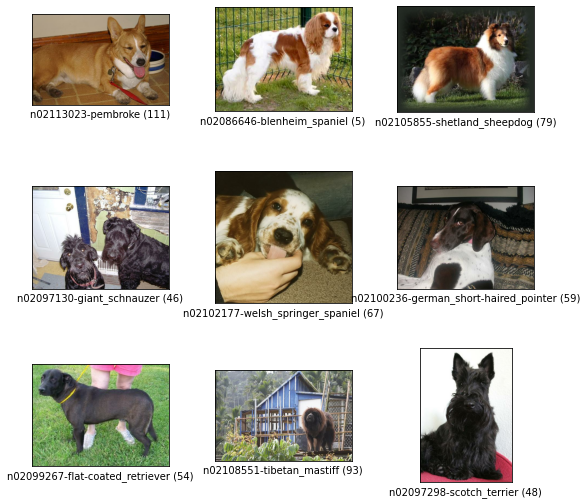

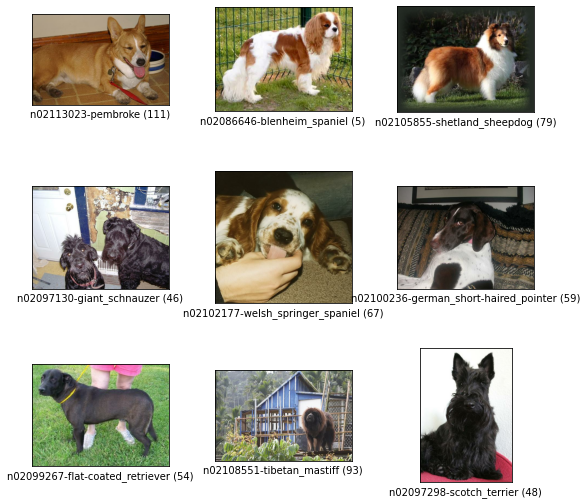

In [5]:
# 데이터 확인

tfds.show_examples(ds_train, ds_info)

### 1. Augmentation을 적용한 데이터셋 만들기

In [6]:
# 데이터셋을 적용하기 이전에 데이터에 대한 기본적인 전처리 과정을 거쳐준다.

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

print('good')

good


In [7]:
# 기본적인 augmentation 적용 함수

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

print('good')

good


In [8]:
# 데이터셋을 가공하는 메인 함수 / with_aug 매개변수를 이용해서 augmentation 적용 여부를 결정할 수 있다.

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


print('제발')

제발


In [9]:
# 아무것도 적용되지 않은 기본 데이터셋 만들기

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

### CutMix가 적용된 데이터셋 만들기

In [10]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

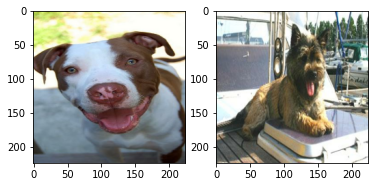

In [11]:
# 데이터셋 2개 가져오기

for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [12]:
# 바운딩 박스 위치 설정

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(40, shape=(), dtype=int32) tf.Tensor(196, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(84, shape=(), dtype=int32)


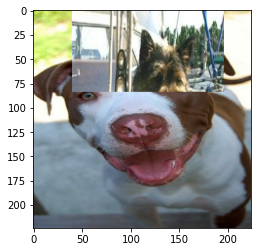

In [13]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [14]:
# 라벨 섞어주기

# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.73883927,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.2611607 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [15]:
# CutMix 함수 구현

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup이 적용된 데이터셋 만들기

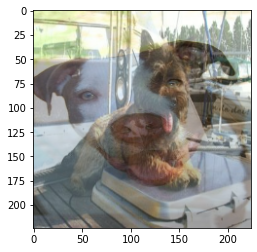

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.47300005
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.52699995
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.    

In [16]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [17]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 모델 구성하기

In [18]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [19]:
# 모델 빌드 함수

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [20]:
# 데이터 생성

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False) # 아무것도 적용안한 기본 데이터셋
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True) # 기본 aug만 적용한 데이터셋
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True) # cutmix를 적용한 데이터셋
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True) # mixup을 적용한 데이터셋
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [21]:
# 기본 모델 빌드

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,   #include_top은 마지막 fully connected layer를 포함할지 여부
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


### 모델 훈련



In [22]:
# 기본 모델 훈련
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
750/750 [==============================] - 106s 119ms/step - loss: 2.1992 - accuracy: 0.4486 - val_loss: 3.6553 - val_accuracy: 0.1674
Epoch 2/20
750/750 [==============================] - 89s 118ms/step - loss: 0.6762 - accuracy: 0.8173 - val_loss: 1.0619 - val_accuracy: 0.6820
Epoch 3/20
750/750 [==============================] - 88s 118ms/step - loss: 0.1864 - accuracy: 0.9640 - val_loss: 0.9073 - val_accuracy: 0.7337
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0481 - accuracy: 0.9967 - val_loss: 0.8964 - val_accuracy: 0.7437
Epoch 5/20
750/750 [==============================] - 88s 118ms/step - loss: 0.0196 - accuracy: 0.9997 - val_loss: 0.8946 - val_accuracy: 0.7464
Epoch 6/20
750/750 [==============================] - 88s 118ms/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.9146 - val_accuracy: 0.7437
Epoch 7/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0169 - accuracy: 0.9992 - val_loss: 0.9305 - val_a

In [23]:
# 기본 aug를 적용한 모델 훈련

EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = resnet50.fit(
    ds_train_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 100s 121ms/step - loss: 0.3750 - accuracy: 0.8925 - val_loss: 1.4850 - val_accuracy: 0.6173
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 0.3087 - accuracy: 0.9127 - val_loss: 1.2592 - val_accuracy: 0.6698
Epoch 3/20
750/750 [==============================] - 89s 118ms/step - loss: 0.1401 - accuracy: 0.9659 - val_loss: 1.6024 - val_accuracy: 0.6170
Epoch 4/20
750/750 [==============================] - 89s 118ms/step - loss: 0.0772 - accuracy: 0.9843 - val_loss: 1.1178 - val_accuracy: 0.7032
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0426 - accuracy: 0.9927 - val_loss: 1.1110 - val_accuracy: 0.7157
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0580 - accuracy: 0.9883 - val_loss: 1.1972 - val_accuracy: 0.7062
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0260 - accuracy: 0.9959 - val_loss: 1.0730 - val_accuracy: 0.

In [24]:
# CutMix를 적용한 모델

EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = resnet50.fit(
    ds_train_cutmix, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
750/750 [==============================] - 103s 123ms/step - loss: 2.3707 - accuracy: 0.6557 - val_loss: 1.6539 - val_accuracy: 0.5785
Epoch 2/20
750/750 [==============================] - 91s 122ms/step - loss: 2.1679 - accuracy: 0.6937 - val_loss: 1.2649 - val_accuracy: 0.6613
Epoch 3/20
750/750 [==============================] - 91s 122ms/step - loss: 2.0899 - accuracy: 0.7163 - val_loss: 1.2814 - val_accuracy: 0.6639
Epoch 4/20
750/750 [==============================] - 91s 121ms/step - loss: 1.9723 - accuracy: 0.7481 - val_loss: 1.3323 - val_accuracy: 0.6583
Epoch 5/20
750/750 [==============================] - 91s 122ms/step - loss: 1.9552 - accuracy: 0.7496 - val_loss: 1.3388 - val_accuracy: 0.6578
Epoch 6/20
750/750 [==============================] - 91s 122ms/step - loss: 1.8711 - accuracy: 0.7718 - val_loss: 1.2570 - val_accuracy: 0.6838
Epoch 7/20
750/750 [==============================] - 91s 122ms/step - loss: 1.8349 - accuracy: 0.7763 - val_loss: 1.4890 - val_a

In [25]:
# Mixup을 적용한 모델

EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = resnet50.fit(
    ds_train_mixup, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 102s 123ms/step - loss: 1.8771 - accuracy: 0.8386 - val_loss: 1.8071 - val_accuracy: 0.5995
Epoch 2/20
750/750 [==============================] - 91s 121ms/step - loss: 1.8311 - accuracy: 0.8422 - val_loss: 1.5376 - val_accuracy: 0.6564
Epoch 3/20
750/750 [==============================] - 92s 122ms/step - loss: 1.7579 - accuracy: 0.8551 - val_loss: 1.5539 - val_accuracy: 0.6581
Epoch 4/20
750/750 [==============================] - 91s 121ms/step - loss: 1.7359 - accuracy: 0.8625 - val_loss: 1.4771 - val_accuracy: 0.6699
Epoch 5/20
750/750 [==============================] - 94s 126ms/step - loss: 1.7267 - accuracy: 0.8593 - val_loss: 1.5717 - val_accuracy: 0.6531
Epoch 6/20
750/750 [==============================] - 92s 122ms/step - loss: 1.7090 - accuracy: 0.8614 - val_loss: 1.5508 - val_accuracy: 0.6536
Epoch 7/20
750/750 [==============================] - 92s 123ms/step - loss: 1.7016 - accuracy: 0.8605 - val_loss: 1.4839 - val_accuracy: 0.

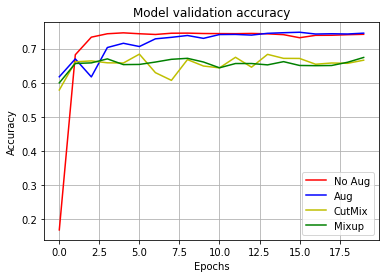

In [28]:
# 시각화하기

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['No Aug', 'Aug', 'CutMix', 'Mixup'], loc = 'lower right')
plt.grid(True)
plt.show()

### 프로젝트 정리

1. 각 모델들의 훈련 결과를 종합해보면 성능순으로는 Aug > No Aug > Mixup > CutMix 순으로 나타났다.
2. CutMix와 Mixup을 적용한 모델은 좀 더 심화된 Augmentation 기법이어서 더 좋은 효과가 나타날 줄 알았는데 오히려 더 낮은 결과값을 보여주었다.
3. 결과가 좋지 못한 이유를 생각해보면 데이터를 잘라서 서로 합쳐서 만든 데이터는 좋은 데이터라고 생각하기 어렵다고 생각한다. 데이터의 양이 많아져서 훈련을 좀 더 많이 시킬 수 있겠지만 결과적으로는 데이터의 질은 나쁘다고 생각한다.
4. 특별히 아쉬운 부분은 좋지 못한 결과를 향상시키기 위해서 어떤 부분에서의 보완이 필요한지 인사이트를 얻지 못했다.
5. 아직 모델을 구성하는 코드들이나 모델의 작동원리에 대해서 완벽하게 이해하지 못해서 수정 및 보완에 있어서도 어려운 것 같다.
6. CV에 관한 모델을 깊이 있게 공부하는 만큼 다른 자료들도 찾아보면서 모델에 대한 이해도를 높여야겠다.

### 프로젝트 회고

1. 코랩으로 프로젝트를 진행하면서 많은 오류들을 경험하는 것 같다.
2. 이번 노드를 진행하면서도 텐서플로우 모델 버전 이슈부터 시작해서 gpu 메모리 문제까지 여러 오류를 해결하기 위해서 많은 시간을 구글링에 사용하였다.
3. 오류에 대해서 구글링을 진행하면 다양한 글들이 있는데 아쉬운 것은 한국어로 된 질문과 답변이 많지 않다는 것이다.
4. 결국 텐서플로우 버전 문제는 구글링도 하고 몇번 재설치도 하면서 해결하였고 특히 모델을 훈련하려하면 gpu 메모리 문제로 오류가 나는 것은 많은 블로그 글들을 읽고 최종적으로 아예 재실행을 하고 난 이후에 해결하였다.
5. 오류에 대해서 사람들이 해결방법으로 제시한 솔루션을 따라해보면서 여러 경험도 해볼 수 있어서 좋았지만 한편으로는 딱 맞는 솔루션을 찾기가 어려워서 생각보다 답답함을 느꼈다.
6. 결국 최종적으로 느낀 것은 코드를 작성할 때 그냥 어디선가 긁어와서 복사 붙여넣기 하는 것이 아닌 코드가 어떻게 구성되어져 있는지 알아야 오류 내용을 보고 어디 부분이 의심스러운지 찾을 수 있고 결국 솔루션을 찾을 수 있기에 시간이 오래 걸리더라고 꼼꼼하게 진행하는게 중요하다는 생각이 들었다.